Transformer及其衍生架构，在自然语言处理上取得了卓越的成果。但是，在将这一范式迁移到时间序列预测上来的时候，却遇到了尴尬的打不过线性模型的困难

首先我们分析一下，NLP（自然语言处理）和TSF（时间序列预测）两个问题的主要差别：

1. 自然语言中的语义既存在在每个单词中，也存在在单词之间的序列关系上。一个句子完全打乱单词顺序，也能保留部分信息（尽管不那么准确）。一个还不懂语法的语言学习者，仅靠单词也可以和其他人勉强交流。但是对于时间序列，打乱顺序就意味着完全丢失信息，可以说时间序列的信息绝大部分都隐藏在序列之中。

2. 自然语言的具有高度的一致性和可迁移性，常见单词和词组的含义在绝大多数语料中都是相近相似的，虽然会有一些多义词但毕竟是少数。而不同的时间序列即使出现了相同的形态，也不能说就有相似含义。例如，在金融领域，某些价格形态会包含价格趋势信息，其底层的逻辑是多空双方的博弈导致的，但是如果这样的形态出现在例如气温序列中，就不能说表示趋势性，因为底层的逻辑完全不一样。

3. 自然语言的训练集非常丰富，在人类历史上积累了大量的训练语料。但由于时间序列的含义差距，每个领域的时间序列是有限的，只能使用当前研究的框架内的数据。一般资产的数据有10年以上已经是非常丰富的历史了。如果扩展序列就会面临结构和范式的变化。

4. 自然语言的模式迁移非常缓慢，几乎可以忽略不记，虽然人类的语言会有所发展和变化，但是这种变化都是以数十年为单位的，在短期内改变的只会有少数词的词义，大的语法是不会改变的。但对于金融数据。概念漂移是非常常见的，时间序列的底层因素，例如次贷危机、疫情的出现很可能直接导致资产的模式完全改变，从而让历史数据的价值大打折扣，进一步加剧了数据量的问题。

Transformer架构能在NLP上取得成功的原因，恰恰也是Transformer架构不能被直接迁移到TSF上的原因：

1. RNN架构的顺序结构会影响长距离信息传递，长距离信息要么随着梯度消失，要么产生梯度爆炸。为了能顺利捕捉长距离关系，Transformer架构可以放弃了RNN架构的顺序性，转而使用并行性保护远距离信息可以顺利传播；

2. 因为采用了并行架构丢失了顺序信息，Transformer架构采用位置编码补齐丢失的顺序信息。但位置编码会影响一部分原始语义信息；

3. 因为训练语料足够丰富，导致位置编码的影响可以被最小化；

4. 平行架构也可以充分运用算力，大幅度加速训练过程，因此可以接受更复杂的模型层数。将牺牲的部分通过更大的模型来弥补。

换言之，因为自然语言的训练资料足够丰富，足以掩盖Transformer架构的缺点，充分发挥Transformer架构的优势，才使得Transformer架构得以在NLP问题上大放异彩。但反过来，在TSF问题上，Transformer架构并没有这样的优势。而其劣势，会被时间序列数据量缺乏的问题放大。Transformer架构本身就很复杂，模型的参数量越大，需要的数据集也就越大，超大的模型可以轻松记忆本就为数不多的数据集导致过拟合，必须对扩展模型保持谨慎态度。

当然，这也并不意味着完全就不能使用Transformer架构。Transformer架构在长距离提取上仍然有优势。具体来说，如果想要充分发挥Transformer架构的优势，我们需要解决如下问题：

1. 每个信息单元包含的信息要足够丰富。自然语言中每个单词的语义已经非常丰富，最新的的大语言模型单个词嵌入维度已经达到了4096甚至更高。而单个时间步的OHLCV数据的维度太小，即使扩展一些辅助信息，也很难从单个时间步得到有效信息进行相互传播。因此，单个信息单元要从时间步提升到子序列级别，比如一个长达10天的子序列，除了10天本身的价格信息以外，还能抽象出某种趋势信息，例如一小段缩量上涨、或者一小段区间的放量震荡等等。通过将多个时间步组合成一个patch的方式，模型可以变为处理一段一段的时间。同时，这样的结构也可以接入更长的历史窗口，绕开Transformer在注意力层的O(N^2)复杂度的限制。

2. 用科学的方式扩展训练集，如果我们的目标是资产价格预测，那么至少训练集的范围可以扩展到其他金融资产，但不应该扩展到非金融的领域。因为价格的底层逻辑是供需关系、多空博弈。同时，还要增加额外的机制让模型理解不同资产之间的差距和联系，例如波动率、相关性、协整性等等。



In [47]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [48]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """
    处理(* , seq_len, feature_dim) tensor，在seq_len维度上添加位置编码。
    """
    def __init__(self, d_model, dropout, max_len = 5000):
        """
            d_model (int): 特征维度 (feature_dim)
            dropout (float): Dropout的概率
            max_len (int): 预先计算编码的最大序列长度
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        assert d_model % 2 == 0, "d_model 必须是偶数"

        position = torch.arange(max_len).unsqueeze(1)


        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(-2)
        pos_encoding = self.pe[:seq_len, :]
        x = x + pos_encoding
        return self.dropout(x)

In [49]:
class PatchProjection(nn.Module):
    def __init__(self, input_size, patch_size, d_model = 128, dropout = 0.1):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        
        self.project = nn.Linear(input_size * patch_size, d_model) # 暂时只使用单层线性投影就够了 暂时不需要做太过深度的信息抽象，这个过程会交给Encoder去完成
        self.pe = PositionalEncoding(d_model = d_model, dropout = dropout)
        
    
    def forward(self, x):
        x = self.project(x)
        x = self.pe(x)
        return x

x = torch.randn(size = (64, 100))
pp = PatchProjection(input_size = 10, patch_size = 10, d_model = 128, dropout = 0.1)
pp(x).shape

torch.Size([64, 128])

In [50]:
from modules.patch import TimeSeriesPatcher
from modules.encoder import MultiLayerEncoder


class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.5,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]


        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        


In [51]:
# 这些参数是两阶段共享的
seq_len = 160
patch_size = 5
batch_size = 32

num_layer = 4
num_head = 4
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

stride = patch_size // 2 # 50% overlap
masking_ratio = 0.2 
mask_expand_size = 1


# 这些参数是可变的
dropout_1 = 0.5
dropout_2 = 0.05
dropout_3 = 0.2

learning_rate = 0.0004063346203116716
weight_decay = 0.0009988629575338828


In [52]:
# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)

feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]

feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

data = RandomLoader(feature, label)
recorder = PredictionRecorder()
animator = TrainMonitor(figsize=(12,6))

In [53]:
# train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.2], balance=[True, False])
# for x, y in test_loader:
#     print(y.shape)

In [ ]:
# 二阶段 prediction训练
def objective(trial):
    
    dropout_1 = trial.suggest_float("dropout_1", 0.4, 0.6)
    dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.1)
    dropout_3 = trial.suggest_float("dropout_3", 0.0, 0.5)

    learning_rate_output = trial.suggest_float("learning_rate_output", 1e-6, 1e-1, log=True)
    weight_decay_output = trial.suggest_float("weight_decay_output", 1e-6, 1e-1, log=True)

    learning_rate_encoder = trial.suggest_float("learning_rate_encoder", 1e-5, 1e-3, log=True)
    weight_decay_encoder = trial.suggest_float("weight_decay_encoder", 1e-4, 1e-2, log=True)

    alpha = trial.suggest_float("alpha", 1e-2, 1e-1, log=True)
    delta = trial.suggest_float('delta', 0.9, 1.4)

    model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')
    
    # # 训练方案1 ：只训练输出层
    # optimizer = torch.optim.AdamW(model.output.parameters(), lr=learning_rate_output, weight_decay = weight_decay_output)
    
    # 训练方案2 ：全局训练，但设置不同学习率
    output_params = model.output.parameters()
    output_param_ids = {id(p) for p in output_params}
    other_params = [p for p in model.parameters() if id(p) not in output_param_ids]
    optimizer_grouped_parameters = [
        {'params': other_params, 'lr': learning_rate_encoder, 'weight_decay': weight_decay_encoder},
        {'params': model.output.parameters(), 'lr': learning_rate_output, 'weight_decay': weight_decay_output}
    ]

    optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

    precision_list = []

    for i in range(10):
        animator.reset()
        train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.2], balance=[True, False])
        loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

        model.load_state_dict(torch.load('params/self_supervised.params'))
        train = ModelTrain(model = model,
                        train_loader = train_loader,
                        test_loader = test_loader,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler = scheduler,
                        recorder = recorder,
                        graph = animator,
                        )
        
        prediction, precision = train.epoch_train(epochs = 5, early_stop = 100)
        precision_list.append(precision)
        
    return np.mean(precision_list)/np.std(precision_list)


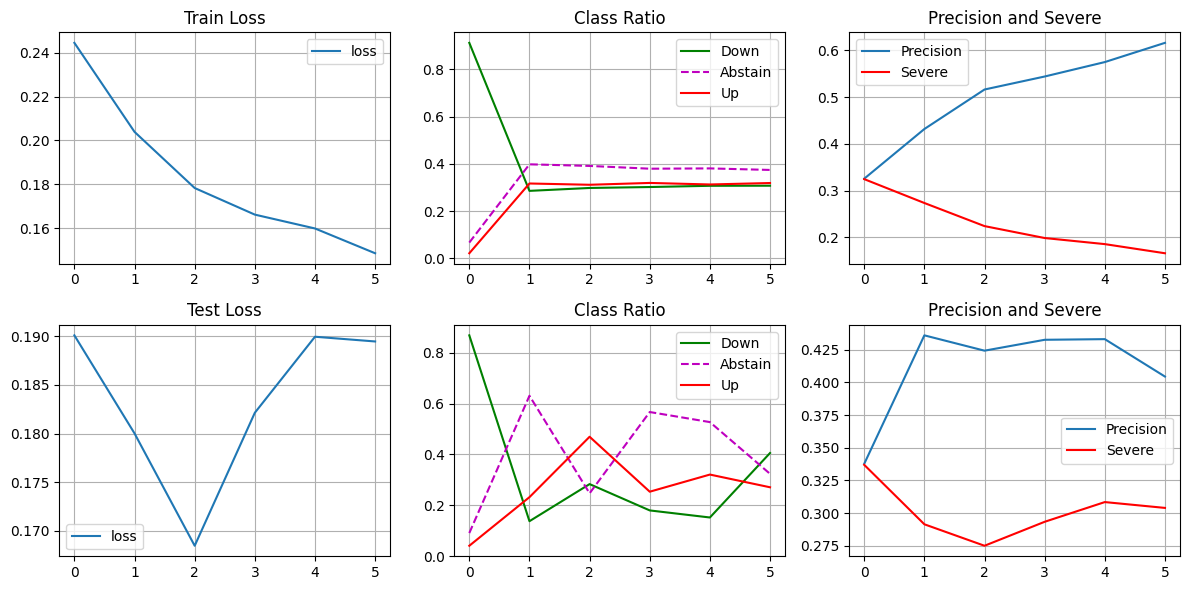

100%|██████████| 45/45 [00:00<00:00, 173.96it/s]
[I 2025-10-05 06:45:19,085] Trial 29 finished with value: 0.3779911288635485 and parameters: {'dropout_1': 0.5354581596655997, 'dropout_2': 0.028388835433953125, 'dropout_3': 0.20916813890619682, 'learning_rate_output': 0.01738118590009047, 'weight_decay_output': 6.177043185263617e-06, 'learning_rate_encoder': 0.0008484645200828332, 'weight_decay_encoder': 0.0004518194829146481, 'alpha': 0.047321069530319546, 'delta': 1.0000581856322097}. Best is trial 5 with value: 4.337344048982032.


最佳准确率:  4.337344048982032
最佳超参数:  {'dropout_1': 0.5448345400604295, 'dropout_2': 0.0012253570978523643, 'dropout_3': 0.15165549924102828, 'learning_rate_output': 1.5582165261027625e-05, 'weight_decay_output': 0.00021915402096764046, 'learning_rate_encoder': 0.0008380572847568955, 'weight_decay_encoder': 0.0002352001284382145, 'alpha': 0.037166939152153064, 'delta': 1.3027658016766466}


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_delta,params_dropout_1,params_dropout_2,params_dropout_3,params_learning_rate_encoder,params_learning_rate_output,params_weight_decay_encoder,params_weight_decay_output,state
28,28,0.200873,2025-10-05 06:38:57.502052,2025-10-05 06:42:05.312424,0 days 00:03:07.810372,0.019110,1.065437,0.515718,0.035791,0.138610,0.000453,0.090791,0.002552,0.001532,COMPLETE
0,0,0.265525,2025-10-05 05:08:04.516115,2025-10-05 05:11:31.669017,0 days 00:03:27.152902,0.054269,1.038731,0.535873,0.029964,0.187568,0.000983,0.018940,0.005204,0.000008,COMPLETE
29,29,0.377991,2025-10-05 06:42:05.312790,2025-10-05 06:45:19.085538,0 days 00:03:13.772748,0.047321,1.000058,0.535458,0.028389,0.209168,0.000848,0.017381,0.000452,0.000006,COMPLETE
9,9,0.381574,2025-10-05 05:37:49.201202,2025-10-05 05:41:01.897769,0 days 00:03:12.696567,0.040397,1.108842,0.481471,0.030281,0.324290,0.000106,0.000003,0.001317,0.000899,COMPLETE
7,7,0.462080,2025-10-05 05:31:25.580299,2025-10-05 05:34:36.850843,0 days 00:03:11.270544,0.013068,1.101326,0.518787,0.010315,0.168310,0.000015,0.000004,0.003871,0.003280,COMPLETE
1,1,0.679607,2025-10-05 05:11:31.669461,2025-10-05 05:14:56.969374,0 days 00:03:25.299913,0.010043,1.102113,0.550551,0.025754,0.034199,0.000051,0.000010,0.000333,0.024790,COMPLETE
24,24,0.746733,2025-10-05 06:25:57.035966,2025-10-05 06:29:10.634366,0 days 00:03:13.598400,0.034111,1.236980,0.569602,0.035984,0.321528,0.000724,0.012197,0.000413,0.001287,COMPLETE
22,22,0.797142,2025-10-05 06:19:30.619787,2025-10-05 06:22:41.403144,0 days 00:03:10.783357,0.013364,1.314763,0.576531,0.016802,0.379601,0.000659,0.005104,0.000103,0.015300,COMPLETE
6,6,0.813143,2025-10-05 05:28:13.421532,2025-10-05 05:31:25.579909,0 days 00:03:12.158377,0.075079,1.030366,0.596696,0.043155,0.081779,0.000041,0.048961,0.000158,0.003983,COMPLETE
14,14,0.889047,2025-10-05 05:53:48.191361,2025-10-05 05:56:59.132516,0 days 00:03:10.941155,0.026028,1.189302,0.431327,0.098355,0.419586,0.000495,0.000010,0.002559,0.000019,COMPLETE


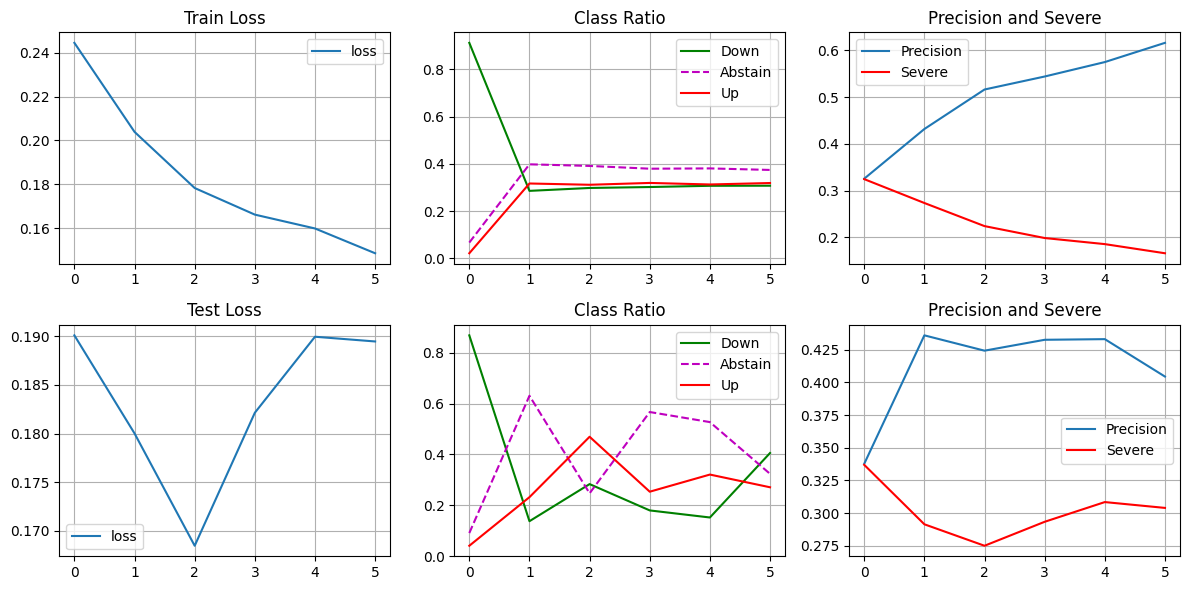

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("最佳准确率: ", study.best_value)
print("最佳超参数: ", study.best_params)
df = study.trials_dataframe()
df.sort_values(by='value', ascending=False)

In [63]:
df.sort_values(by='value', ascending=False).head(5).describe().loc['mean']

number                                                   10.0
value                                                2.475381
datetime_start                  2025-10-05 05:40:51.365839872
datetime_complete               2025-10-05 05:44:11.139628800
duration                            0 days 00:03:19.773788800
params_alpha                                         0.027766
params_delta                                         1.198406
params_dropout_1                                     0.524036
params_dropout_2                                     0.029142
params_dropout_3                                     0.338071
params_learning_rate_encoder                         0.000381
params_learning_rate_output                          0.001012
params_weight_decay_encoder                          0.000674
params_weight_decay_output                           0.001773
Name: mean, dtype: object

In [57]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [58]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()


最佳准确率:  4.337344048982032
最佳超参数:  {'dropout_1': 0.5448345400604295, 'dropout_2': 0.0012253570978523643, 'dropout_3': 0.15165549924102828, 'learning_rate_output': 1.5582165261027625e-05, 'weight_decay_output': 0.00021915402096764046, 'learning_rate_encoder': 0.0008380572847568955, 'weight_decay_encoder': 0.0002352001284382145, 'alpha': 0.037166939152153064, 'delta': 1.3027658016766466}

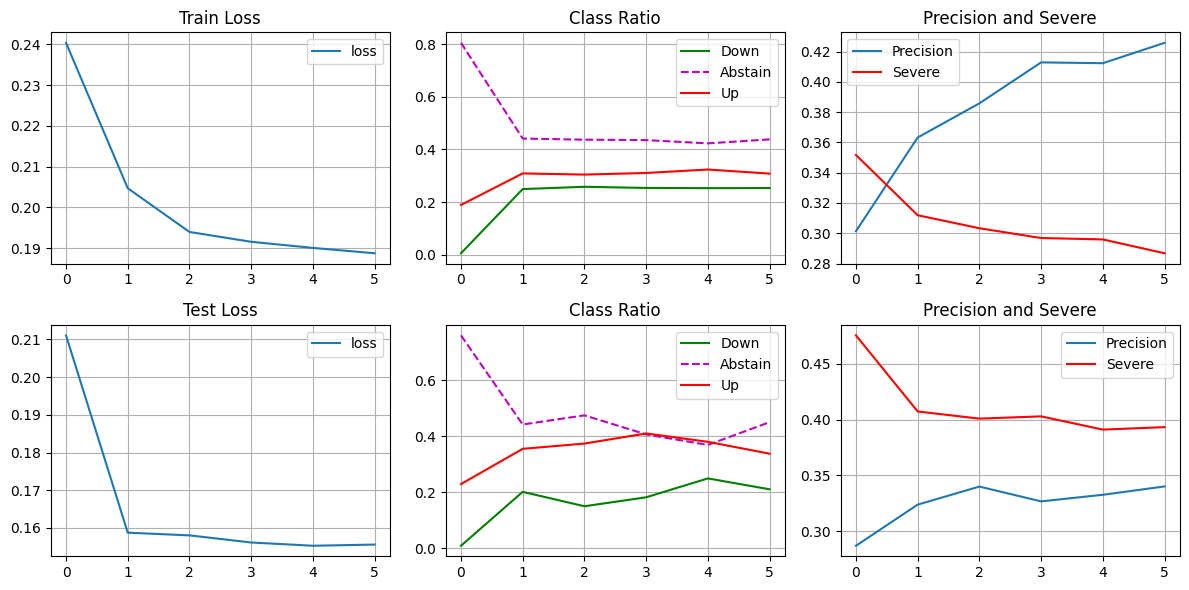

100%|██████████| 45/45 [00:00<00:00, 163.54it/s]


(np.float64(0.05701477934961367), np.float64(0.04837001392223331))

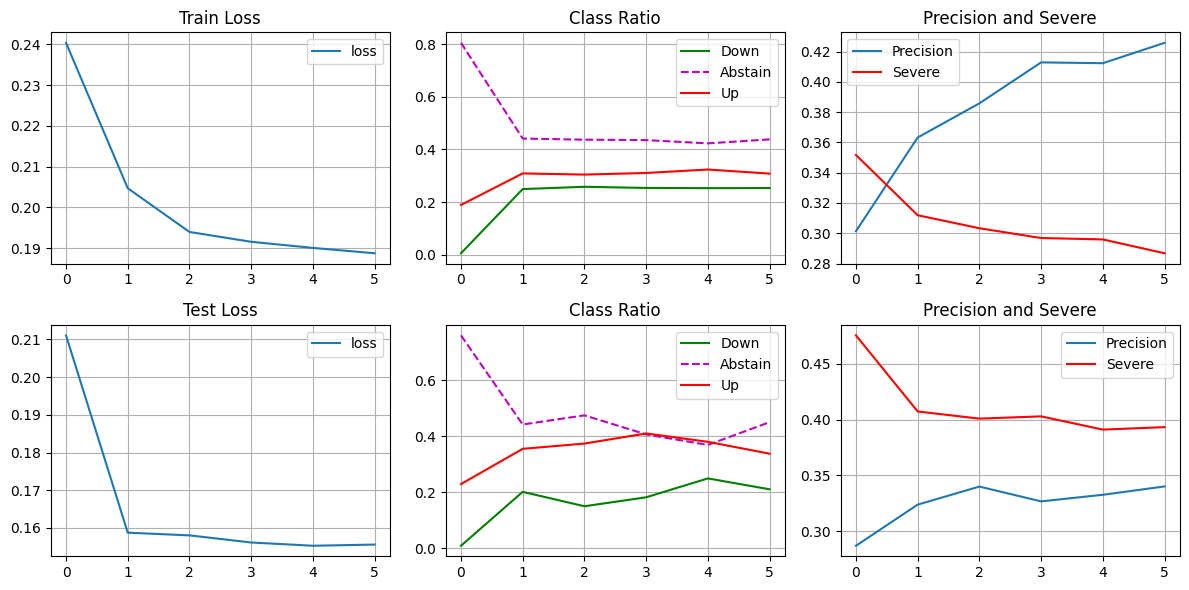

In [69]:
# 按照最优参数训练和保存模型
# 这些参数是两阶段共享的
seq_len = 160
patch_size = 5
batch_size = 32

num_layer = 4
num_head = 4
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

stride = patch_size // 2 # 50% overlap
masking_ratio = 0.2 
mask_expand_size = 1


dropout_1 = 0.544834540060429
dropout_2 = 0.0012253570978523643
dropout_3 = 0.15165549924102828

learning_rate_output = 1.5582165261027625e-05
weight_decay_output = 0.00021915402096764046

learning_rate_encoder = 0.0008380572847568955
weight_decay_encoder = 0.0002352001284382145

alpha = 0.037166939152153064
delta = 1.3027658016766466


# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])


loss_fn = nn.MSELoss()
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')


    

    
# 全局训练，但设置不同学习率
output_params = model.output.parameters()
output_param_ids = {id(p) for p in output_params}
other_params = [p for p in model.parameters() if id(p) not in output_param_ids]
optimizer_grouped_parameters = [
        {'params': other_params, 'lr': learning_rate_encoder, 'weight_decay': weight_decay_encoder},
        {'params': model.output.parameters(), 'lr': learning_rate_output, 'weight_decay': weight_decay_output}
    ]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

precision_list = []

for i in range(10):
    animator.reset()
    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.2], balance=[True, False])
    loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    model.load_state_dict(torch.load('params/self_supervised.params'))
    train = ModelTrain(model = model,
                        train_loader = train_loader,
                        test_loader = test_loader,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler = scheduler,
                        recorder = recorder,
                        graph = animator,
                        )
        
    prediction, precision = train.epoch_train(epochs = 5, early_stop = 100)
    precision_list.append(precision)

np.mean(precision_list), np.std(precision_list)

In [64]:
df.sort_values(by='value', ascending=False).head(5).describe().loc['mean']

number                                                   10.0
value                                                2.475381
datetime_start                  2025-10-05 05:40:51.365839872
datetime_complete               2025-10-05 05:44:11.139628800
duration                            0 days 00:03:19.773788800
params_alpha                                         0.027766
params_delta                                         1.198406
params_dropout_1                                     0.524036
params_dropout_2                                     0.029142
params_dropout_3                                     0.338071
params_learning_rate_encoder                         0.000381
params_learning_rate_output                          0.001012
params_weight_decay_encoder                          0.000674
params_weight_decay_output                           0.001773
Name: mean, dtype: object

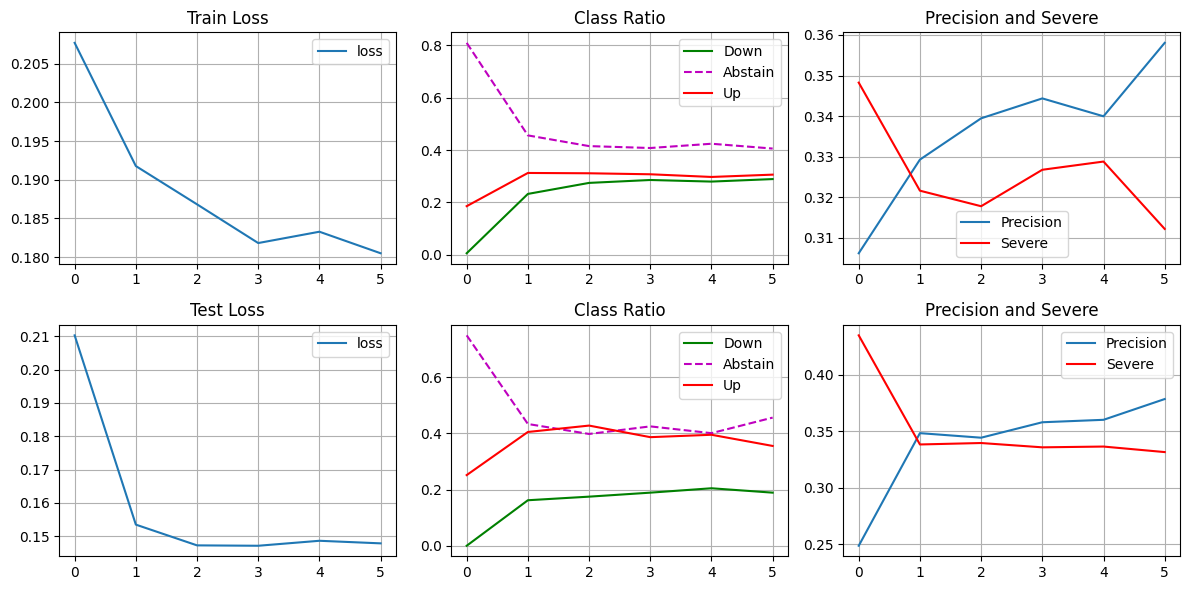

100%|██████████| 22/22 [00:00<00:00, 167.81it/s]


(np.float64(0.046394705104127285), np.float64(0.03802186646360737))

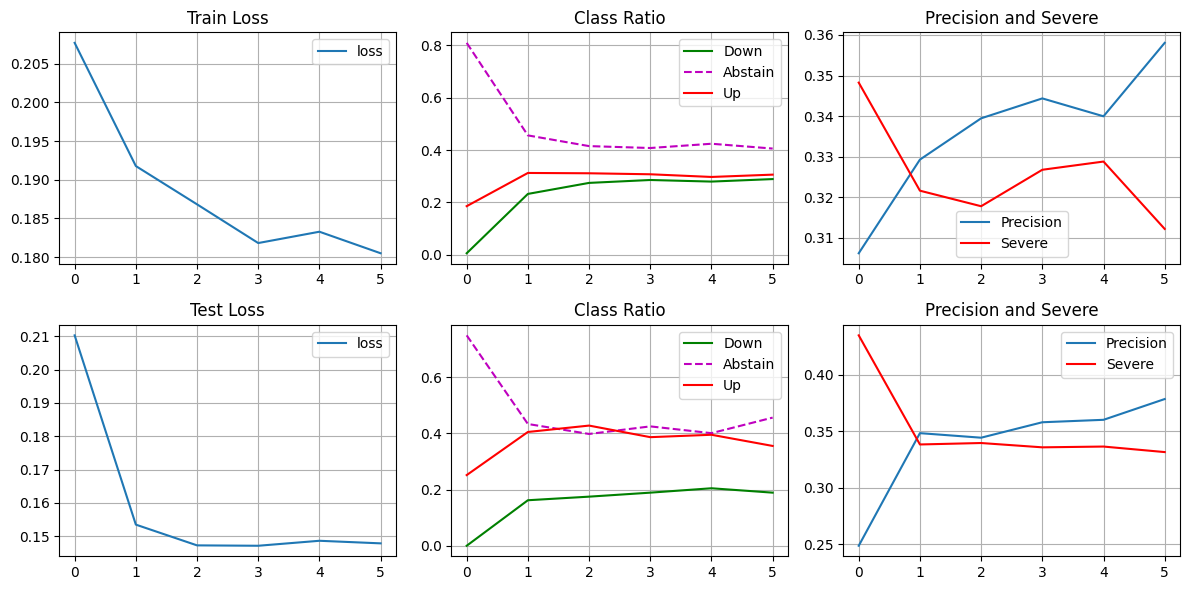

In [ ]:
# 按照最优参数训练和保存模型
# 这些参数是两阶段共享的
seq_len = 160
patch_size = 5
batch_size = 32

num_layer = 4
num_head = 4
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

stride = patch_size // 2 # 50% overlap
masking_ratio = 0.2 
mask_expand_size = 1


dropout_1 = 0.5240355900271978
dropout_2 = 0.029142367261375056
dropout_3 = 0.33807103347480894

learning_rate_output = 0.0001
weight_decay_output = 0.001

learning_rate_encoder = 0
weight_decay_encoder = 0

alpha = 0.027766085433800557
delta = 1.198406284984316


# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])


loss_fn = nn.MSELoss()
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

    
# 全局训练，但设置不同学习率
output_params = model.output.parameters()
output_param_ids = {id(p) for p in output_params}
other_params = [p for p in model.parameters() if id(p) not in output_param_ids]
optimizer_grouped_parameters = [
        {'params': other_params, 'lr': learning_rate_encoder, 'weight_decay': weight_decay_encoder},
        {'params': model.output.parameters(), 'lr': learning_rate_output, 'weight_decay': weight_decay_output}
    ]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

precision_list = []

for i in range(10):
    animator.reset()
    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.1], balance=[True, False])
    loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    model.load_state_dict(torch.load('params/self_supervised.params'))
    train = ModelTrain(model = model,
                        train_loader = train_loader,
                        test_loader = test_loader,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler = scheduler,
                        recorder = recorder,
                        graph = animator,
                        )
        
    prediction, precision = train.epoch_train(epochs = 5, early_stop = 100)
    precision_list.append(precision)

torch.save(model.state_dict(), 'params/supervised.params')

np.mean(precision_list), np.std(precision_list)

In [ ]:
# all_assets = pd.DataFrame({
#     'stage_1_prediction': np.mean(result, axis = 0)[:,0],
#     'stage_2_prediction': np.mean(result, axis = 0)[:,2],

#     'stage_1_precision': np.mean(result, axis = 0)[:,1],
#     'stage_2_precision': np.mean(result, axis = 0)[:,3],

#     'stage_1_precision_std': np.std(result, axis = 0)[:,1],
#     'stage_2_precision_std': np.std(result, axis = 0)[:,3],
# })
# # all_assets.index = pd.Series(assets_list)
# for col in all_assets.columns:
#     all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# # 转换为Markdown
# markdown_table = all_assets.to_markdown(index=False)
# print(markdown_table)